In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
import astropy
from astropy import constants as ac
import lightkurve as lk
from scipy.optimize import minimize
from astropy.io import fits
from astropy.table import Table
from lightkurve import search_lightcurvefile
from lightkurve import search_lightcurve
from lightkurve import search_targetpixelfile

#import exoplanet as xo

Fitting a transit model using the exoplanet/PyMC3 framework: https://gallery.exoplanet.codes/tutorials/transit/#the-transit-model-in-pymc3


https://gallery.exoplanet.codes/tutorials/tess/

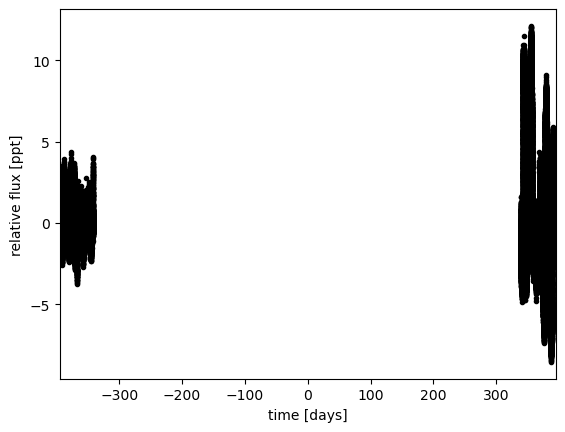

In [2]:
lc_file = lk.search_lightcurve( "TIC 77175217", exptime=120, author="SPOC").download_all(quality_bitmask="hardest", flux_column="pdcsap_flux")
lc = lc_file.stitch().remove_outliers().remove_nans()
time = lc.time.value
flux = lc.flux


with fits.open(lc.filename) as hdu:
    hdr = hdu[1].header

texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

ref_time = 0.5 * (np.min(time) + np.max(time))
x = np.ascontiguousarray(time - ref_time, dtype=np.float64)
y = np.ascontiguousarray(1e3 * (flux - 1.0), dtype=np.float64)

plt.plot(x, y, ".k")
plt.xlabel("time [days]")
plt.ylabel("relative flux [ppt]")
_ = plt.xlim(x.min(), x.max())

In [3]:
lc_file

LightCurveCollection of 4 objects:
    0: <TessLightCurve LABEL="TIC 77175217" SECTOR=4 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    1: <TessLightCurve LABEL="TIC 77175217" SECTOR=5 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    2: <TessLightCurve LABEL="TIC 77175217" SECTOR=31 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>
    3: <TessLightCurve LABEL="TIC 77175217" SECTOR=32 AUTHOR=SPOC FLUX_ORIGIN=pdcsap_flux>

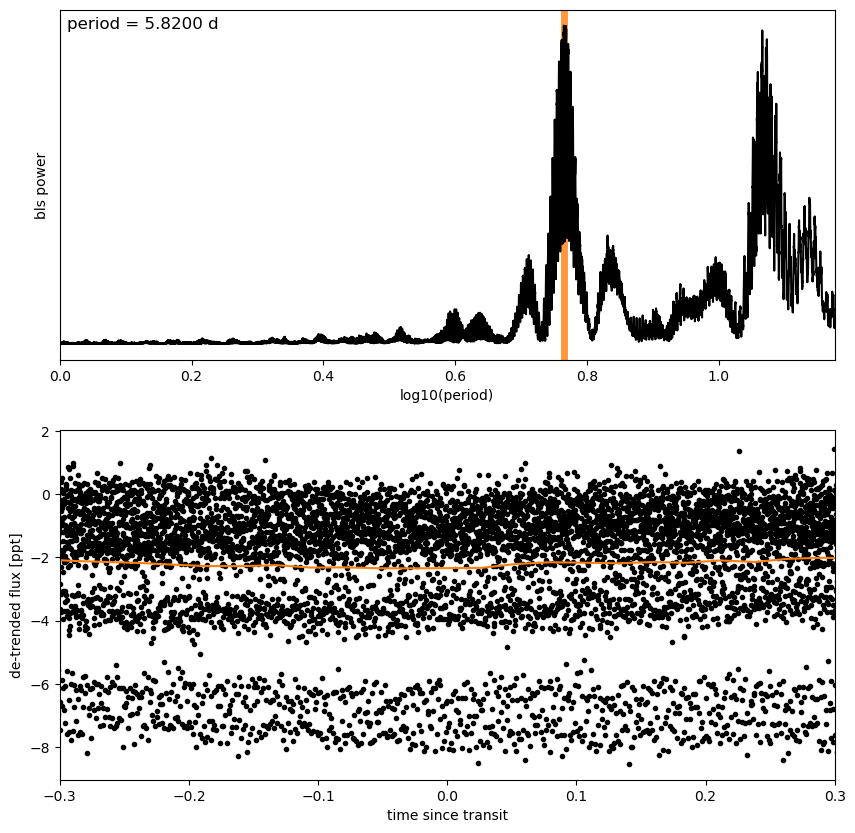

In [4]:
from astropy.timeseries import BoxLeastSquares

period_grid = np.exp(np.linspace(np.log(1), np.log(15), 50000))

bls = BoxLeastSquares(x, y)
bls_power = bls.power(period_grid, 0.1, oversample=20)

# Save the highest peak as the planet candidate
index = np.argmax(bls_power.power)
bls_period = bls_power.period[index]
bls_t0 = bls_power.transit_time[index]
bls_depth = bls_power.depth[index]
transit_mask = bls.transit_mask(x, bls_period, 0.2, bls_t0)

fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Plot the periodogram
ax = axes[0]
ax.axvline(np.log10(bls_period), color="C1", lw=5, alpha=0.8)
ax.plot(np.log10(bls_power.period), bls_power.power, "k")
ax.annotate(
    "period = {0:.4f} d".format(bls_period),
    (0, 1),
    xycoords="axes fraction",
    xytext=(5, -5),
    textcoords="offset points",
    va="top",
    ha="left",
    fontsize=12,
)
ax.set_ylabel("bls power")
ax.set_yticks([])
ax.set_xlim(np.log10(period_grid.min()), np.log10(period_grid.max()))
ax.set_xlabel("log10(period)")

# Plot the folded transit
ax = axes[1]
x_fold = (x - bls_t0 + 0.5 * bls_period) % bls_period - 0.5 * bls_period
m = np.abs(x_fold) < 0.4
ax.plot(x_fold[m], y[m], ".k")

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 32)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=y)
denom[num == 0] = 1.0
ax.plot(0.5 * (bins[1:] + bins[:-1]), num / denom, color="C1")

ax.set_xlim(-0.3, 0.3)
ax.set_ylabel("de-trended flux [ppt]")
_ = ax.set_xlabel("time since transit")

In [5]:
import pymc3

In [6]:
import theano

In [7]:
import aesara_theano_fallback.tensor as tt

In [8]:
import exoplanet as xo

In [9]:
import pymc3 as pm
import pymc3_ext as pmx

In [10]:
from celerite2.theano import terms, GaussianProcess

In [11]:
phase_lc = np.linspace(-.3, .3, 100)

In [12]:
def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
        
    with pm.Model() as model:
        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        u_star = xo.QuadLimbDark("u_star")
        star = xo.LimbDarkLightCurve(u_star)

        # Stellar parameters from TFOP
        M_star = 0.286,0.020
        R_star = 0.308,0.009
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal(
            "m_star", mu=M_star[0], sd=M_star[1]
        )
        r_star = BoundedNormal(
            "r_star", mu=R_star[0], sd=R_star[1]
        )

        # Orbital parameters for the planets
        t0 = pm.Normal("t0", mu=bls_t0, sd=1)
        log_period = pm.Normal("log_period", mu=np.log(bls_period), sd=1)
        period = pm.Deterministic("period", pm.math.exp(log_period))

        # Fit in terms of transit depth (assuming b<1)
        b = pm.Uniform("b", lower=0, upper=2)
        log_depth = pm.Normal("log_depth", mu=np.log(bls_depth), sigma=2.0)
        ror = pm.Deterministic(
            "ror",
            star.get_ror_from_approx_transit_depth(
                1e-3 * pm.math.exp(log_depth), b
            ),
        )
        r_pl = pm.Deterministic("r_pl", ror * r_star)
        
        ecs = pmx.UnitDisk("ecs", testval=np.array([0.01, 0.0]))
        ecc = pm.Deterministic("ecc", pm.math.sum(ecs**2))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
        xo.eccentricity.kipping13("ecc_prior", fixed=True, observed=ecc)

        # Transit jitter & GP parameters
        log_sigma_lc = pm.Normal(
            "log_sigma_lc", mu=np.log(np.std(y[mask])), sd=10
        )
        log_rho_gp = pm.Normal("log_rho_gp", mu=0, sd=10)
        log_sigma_gp = pm.Normal(
            "log_sigma_gp", mu=np.log(np.std(y[mask])), sd=10
        )

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star,
            m_star=m_star,
            period=period,
            t0=t0,
            b=b,
            ecc=ecc,
            omega=omega,
        )

        # Compute the model light curve
        light_curves = (
            star.get_light_curve(orbit=orbit, r=r_pl, t=x[mask], texp=texp)
            * 1e3
        )
        light_curve = pm.math.sum(light_curves, axis=-1) + mean
        resid = y[mask] - light_curve

        # GP model for the light curve
        kernel = terms.SHOTerm(
            sigma=pm.math.exp(log_sigma_gp),
            rho=pm.math.exp(log_rho_gp),
            Q=1 / np.sqrt(2),
        )
        gp = GaussianProcess(kernel, t=x[mask], yerr=pm.math.exp(log_sigma_lc))
        gp.marginal("gp", observed=resid)
        #         pm.Deterministic("gp_pred", gp.predict(resid))

        # Compute and save the phased light curve models
        pm.Deterministic(
            "lc_pred",
            1e3
            * star.get_light_curve(
                orbit=orbit, r=r_pl, t=t0 + phase_lc, texp=texp
            )[..., 0],
        )

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = pmx.optimize(
            start=start, vars=[log_sigma_lc, log_sigma_gp, log_rho_gp]
        )
        map_soln = pmx.optimize(start=map_soln, vars=[log_depth])
        map_soln = pmx.optimize(start=map_soln, vars=[b])
        map_soln = pmx.optimize(start=map_soln, vars=[log_period, t0])
        map_soln = pmx.optimize(start=map_soln, vars=[u_star])
        map_soln = pmx.optimize(start=map_soln, vars=[log_depth])
        map_soln = pmx.optimize(start=map_soln, vars=[b])
        map_soln = pmx.optimize(start=map_soln, vars=[ecs])
        map_soln = pmx.optimize(start=map_soln, vars=[mean])
        map_soln = pmx.optimize(
            start=map_soln, vars=[log_sigma_lc, log_sigma_gp, log_rho_gp]
        )
        map_soln = pmx.optimize(start=map_soln)

        extras = dict(
            zip(
                ["light_curves", "gp_pred"],
                pmx.eval_in_model([light_curves, gp.predict(resid)], map_soln),
            )
        )

    return model, map_soln, extras
model0, map_soln0, extras0 = build_model()

optimizing logp for variables: [log_rho_gp, log_sigma_gp, log_sigma_lc]


message: Desired error not necessarily achieved due to precision loss.
logp: -148389.17116270371 -> -42728.547635996576
optimizing logp for variables: [log_depth]


message: Optimization terminated successfully.
logp: -42728.547635996576 -> -41334.587178837
optimizing logp for variables: [b]


message: NaN result encountered.
logp: -41334.587178837 -> -41334.587178837
optimizing logp for variables: [t0, log_period]


message: Desired error not necessarily achieved due to precision loss.
logp: -41334.58717883699 -> -41333.06939619252
optimizing logp for variables: [u_star]


message: Optimization terminated successfully.
logp: -41333.06939619252 -> -41333.05782198974
optimizing logp for variables: [log_depth]


message: Optimization terminated successfully.
logp: -41333.05782198974 -> -41332.35596209104
optimizing logp for variables: [b]


/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:403: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)


message: Desired error not necessarily achieved due to precision loss.
logp: -41332.35596209104 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model
optimizing logp for variables: [ecs]


message: Optimization terminated successfully.
logp: -41332.35596209104 -> -41331.74973822397
optimizing logp for variables: [mean]


message: Optimization terminated successfully.
logp: -41331.74973822397 -> -41330.3077889455
optimizing logp for variables: [log_rho_gp, log_sigma_gp, log_sigma_lc]


message: Optimization terminated successfully.
logp: -41330.3077889455 -> -40260.1203032647
optimizing logp for variables: [log_sigma_gp, log_rho_gp, log_sigma_lc, ecs, log_depth, b, log_period, t0, r_star, m_star, u_star, mean]


message: Desired error not necessarily achieved due to precision loss.
logp: -40260.1203032647 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model


Plot Results

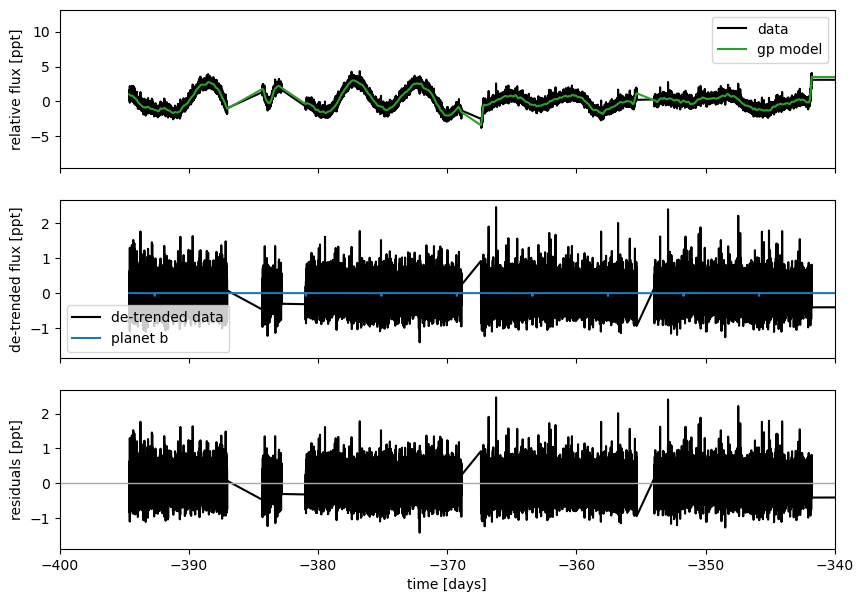

In [13]:

def plot_light_curve(soln, extras, mask=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)

    fig, axes = plt.subplots(3, 1, figsize=(10, 7), sharex=True)

    ax = axes[0]
    ax.plot(x[mask], y[mask], "k", label="data")
    gp_mod = extras["gp_pred"] + soln["mean"]
    ax.plot(x[mask], gp_mod, color="C2", label="gp model")
    ax.legend(fontsize=10)
    ax.set_ylabel("relative flux [ppt]")

    ax = axes[1]
    ax.plot(x[mask], y[mask] - gp_mod, "k", label="de-trended data")
    for i, l in enumerate("b"):
        mod = extras["light_curves"][:, i]
        ax.plot(x[mask], mod, label="planet {0}".format(l))
    ax.legend(fontsize=10, loc=3)
    ax.set_ylabel("de-trended flux [ppt]")

    ax = axes[2]
    mod = gp_mod + np.sum(extras["light_curves"], axis=-1)
    ax.plot(x[mask], y[mask] - mod, "k")
    ax.axhline(0, color="#aaaaaa", lw=1)
    ax.set_ylabel("residuals [ppt]")
    ax.set_xlim(x[mask].min(), x[mask].max())
    ax.set_xlabel("time [days]")
    #ax.set_xlim(340,350)
    ax.set_xlim(-400,-340)
    return fig


_ = plot_light_curve(map_soln0, extras0)


Sigma Clip Outliers

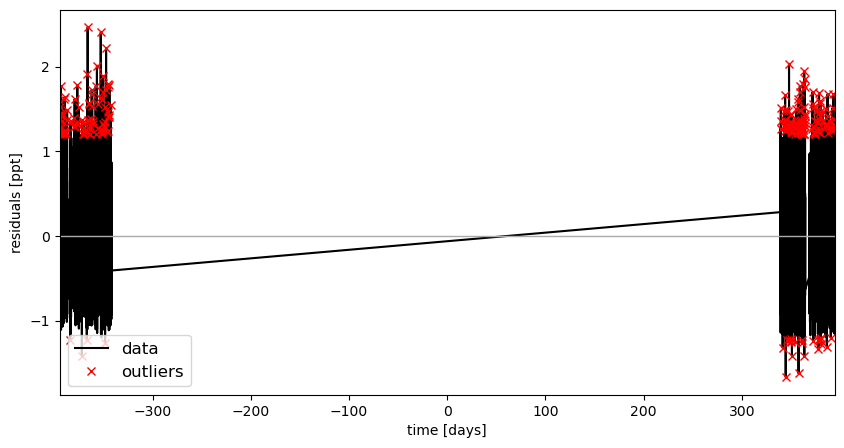

In [14]:
mod = (
    extras0["gp_pred"]
    + map_soln0["mean"]
    + np.sum(extras0["light_curves"], axis=-1)
)
resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 5 * rms

plt.figure(figsize=(10, 5))
plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=3)
_ = plt.xlim(x.min(), x.max())

Rebuild model w/o outliers

optimizing logp for variables: [log_rho_gp, log_sigma_gp, log_sigma_lc]


message: Optimization terminated successfully.
logp: -38598.8839944355 -> -38560.3713849234
optimizing logp for variables: [log_depth]


message: Optimization terminated successfully.
logp: -38560.3713849234 -> -38560.23413204926
optimizing logp for variables: [b]


/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:153: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/scipy/optimize/linesearch.py:403: RuntimeWarning: invalid value encountered in double_scalars
  alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)


message: Desired error not necessarily achieved due to precision loss.
logp: -38560.23413204926 -> nan
final logp not finite, returning initial point
this suggests that something is wrong with the model
optimizing logp for variables: [t0, log_period]


message: Optimization terminated successfully.
logp: -38560.234132049256 -> -38560.11105644962
optimizing logp for variables: [u_star]


message: Optimization terminated successfully.
logp: -38560.11105644961 -> -38560.08315574888
optimizing logp for variables: [log_depth]


message: Optimization terminated successfully.
logp: -38560.08315574888 -> -38560.05870024905
optimizing logp for variables: [b]


message: NaN result encountered.
logp: -38560.05870024905 -> -38560.05870024905
optimizing logp for variables: [ecs]


message: Optimization terminated successfully.
logp: -38560.05870024905 -> -38560.052333127096
optimizing logp for variables: [mean]


message: Optimization terminated successfully.
logp: -38560.052333127096 -> -38559.93994885284
optimizing logp for variables: [log_rho_gp, log_sigma_gp, log_sigma_lc]


message: Optimization terminated successfully.
logp: -38559.93994885284 -> -38559.93979815414
optimizing logp for variables: [log_sigma_gp, log_rho_gp, log_sigma_lc, ecs, log_depth, b, log_period, t0, r_star, m_star, u_star, mean]


message: NaN result encountered.
logp: -38559.93979815414 -> -38559.93979815414


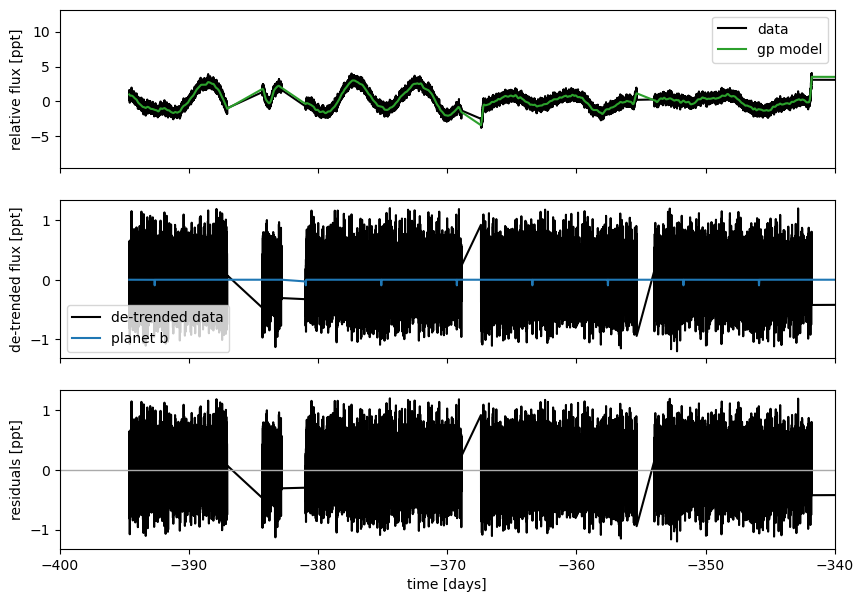

In [15]:
model, map_soln, extras = build_model(mask, map_soln0)
_ = plot_light_curve(map_soln, extras, mask)

Sample from model

In [20]:
import platform

with model:
    trace = pm.sample(
        tune=1500,
        draws=1000,
        start=map_soln,
        # Parallel sampling runs poorly or crashes on macos
        cores=1 if platform.system() == "Darwin" else 2,
        chains=2,
        target_accept=0.95,
        return_inferencedata=True,
        random_seed=[261136679, 261136680],
        init="adapt_full",
    )

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/pymc3/step_methods/hmc/quadpotential.py:514: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Sequential sampling (2 chains in 1 job)
NUTS: [log_sigma_gp, log_rho_gp, log_sigma_lc, ecs, log_depth, b, log_period, t0, r_star, m_star, u_star, mean]


Sampling 2 chains for 1_500 tune and 1_000 draw iterations (3_000 + 2_000 draws total) took 214 seconds.
/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.0, but should be close to 0.95. Try to increase the number of tuning steps.
The chain contains only diverging samples. The model is probably misspecified.
The acceptance probability does not match the target. It is 0.0, but should be close to 0.95. Try to increase the number of tuning steps.


In [17]:
import arviz as az

az.summary(
    trace,
    var_names=[
        "omega",
        "ecc",
        "r_pl",
        "b",
        "t0",
        "period",
        "r_star",
        "m_star",
        "u_star",
        "mean",
    ],
)

ValueError: Can only convert xarray dataarray, xarray dataset, dict, netcdf filename, numpy array, pystan fit, pymc3 trace, emcee fit, pyro mcmc fit, numpyro mcmc fit, cmdstan fit csv filename, cmdstanpy fit to InferenceData, not function

Folded light curve

In [18]:
flat_samps = trace.posterior.stack(sample=("chain", "draw"))

# Compute the GP prediction
gp_mod = extras["gp_pred"] + map_soln["mean"]  # np.median(
#     flat_samps["gp_pred"].values + flat_samps["mean"].values[None, :], axis=-1
# )

# Get the posterior median orbital parameters
p = np.median(flat_samps["period"])
t0 = np.median(flat_samps["t0"])

# Plot the folded data
x_fold = (x[mask] - t0 + 0.5 * p) % p - 0.5 * p
plt.plot(x_fold, y[mask] - gp_mod, ".k", label="data", zorder=-1000)

# Overplot the phase binned light curve
bins = np.linspace(-0.41, 0.41, 50)
denom, _ = np.histogram(x_fold, bins)
num, _ = np.histogram(x_fold, bins, weights=y[mask])
denom[num == 0] = 1.0
plt.plot(
    0.5 * (bins[1:] + bins[:-1]), num / denom, "o", color="C2", label="binned"
)

# Plot the folded model
pred = np.percentile(flat_samps["lc_pred"], [16, 50, 84], axis=-1)
plt.plot(phase_lc, pred[1], color="C1", label="model")
art = plt.fill_between(
    phase_lc, pred[0], pred[2], color="C1", alpha=0.5, zorder=1000
)
art.set_edgecolor("none")

# Annotate the plot with the planet's period
txt = "period = {0:.5f} +/- {1:.5f} d".format(
    np.mean(flat_samps["period"].values), np.std(flat_samps["period"].values)
)
plt.annotate(
    txt,
    (0, 0),
    xycoords="axes fraction",
    xytext=(5, 5),
    textcoords="offset points",
    ha="left",
    va="bottom",
    fontsize=12,
)

plt.legend(fontsize=10, loc=4)
plt.xlim(-0.5 * p, 0.5 * p)
plt.xlabel("time since transit [days]")
plt.ylabel("de-trended flux")
_ = plt.xlim(-0.15, 0.15)

AttributeError: 'function' object has no attribute 'posterior'

corner plots

In [19]:
import corner
import astropy.units as u

trace.posterior["r_earth"] = (
    trace.posterior["r_pl"].coords,
    (trace.posterior["r_pl"].values * u.R_sun).to(u.R_earth).value,
)

_ = corner.corner(
    trace,
    var_names=["period", "r_earth", "b", "ecc"],
    labels=[
        "period [days]",
        "radius [Earth radii]",
        "impact param",
        "eccentricity",],
)


AttributeError: 'function' object has no attribute 'posterior'